# Indonesian LocalX Machine Translation

Indonesia have more than 17,000 islands, 360 ethnic groups, and 840 regional languages, Indonesia faces unique challenges in communication and socialization between its people. Moreover, without using it, our language can potentially become extinct.

This project aims to bridge this communication gap and increase the frequency of local language usage by creating a translation engine that can facilitate daily interactions.

So in this notebook we gonna train T5 model using all available languages in dataset NusaX

## Install Import Dependencies

### Install

In [2]:
!pip install transformers[torch]
!pip install --upgrade pyarrow
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.2 MB/s eta 0:00:0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Bleurt for metrics evaluation

In [3]:
!pip install git+https://github.com/google-research/bleurt.git

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-vn438l8i
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-vn438l8i
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=a3d247c42bdce9329b5aa223a30adc8d1869d88b252e6515b706cdd5edbd84be
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlhtroev/wheels/64/f4/2c/509a6c31b8ebde891a81029fd94f199b1b92f0e7cfc20d417a
Successfully built BLEURT


### Import

In [4]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Mapping the languages


First you can devine the specific translation from what languages that available in NusaX:

- ace: acehnese,
- ban: balinese,
- bjn: banjarese,
- bug: buginese,
- eng: english,
- ind: indonesian,
- jav: javanese,
- mad: madurese,
- min: minangkabau,
- nij: ngaju,
- sun: sundanese,
- bbc: toba_batak,

In [5]:
languages = [
    {
        'code': 'eng',
        'name': 'English',
    },
    {
        'code': 'ind',
        'name': 'Indonesian',
    },
    {
        'code': 'ace',
        'name': 'Acehnese'
    },
    {
        'code': 'ban',
        'name': 'Balinese'
    },
    {
        'code': 'bjn',
        'name': 'Banjarese',
    },
    {
        'code': 'bug',
        'name': 'Buginese',
    },
    {
        'code': 'jav',
        'name': 'Javanese',
    },
    {
        'code': 'mad',
        'name': 'Madurese',
    },
    {
        'code': 'min',
        'name': 'Minangkabau',
    },
    {
        'code': 'nij',
        'name': 'Ngaju'
    },
    {
        'code': 'sun',
        'name': 'Sundanese',
    },
    {
        'code': 'bbc',
        'name': 'Toba_Batak'
    },
]

source = 'sun'
target = 'ind'
source_name = next(item['name'] for item in languages if item['code'] == source)
target_name = next(item['name'] for item in languages if item['code'] == target)

prefix = f'Translate {source_name} to {target_name} : '

# print(f"""
#     Source: {source}
#     Target: {target}
#     Prefix: {prefix}
# """)

## Load Datasets

After specified the translation task you can start loading the datasets or you also can run all the cell.

In [6]:
nusax = load_dataset("indonlp/NusaX-MT")

display(nusax)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

## EDA

Before using the datasets we should do some Exploratory to gain more information about the datasets

#### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [7]:
nusax_df_train = nusax['train'].to_pandas()
nusax_df_test = nusax['test'].to_pandas()
nusax_df_valid = nusax['validation'].to_pandas()

display(nusax_df_train)
print('#'*100)
display(nusax_df_test)
print('#'*100)
display(nusax_df_valid)

id                                             text_1  \
0          0  Neumeuseunang ngon neubayeue bacut-bacut angsu...   
1          1  Kueh nyang dihidang peuingat lon masa dilee. B...   
2          2              Ibu tom geukereuja bak Grab Indonesia   
3          3  Paleng galak ta pajoh bu leuho inoe, manok ngo...   
4          4                     Peulayanan bus DAMRI cukop get   
...      ...                                                ...   
65995  65995  Si A pangkataionna tong kosong nyaring bunyina...   
65996  65996  Sambalna dang nahaluluan di inganan na asing. ...   
65997  65997  Pandapothu lumayan do hu lala steak nai, alai ...   
65998  65998  radotu sipanganon on dah gus na lagi musim na ...   
65999  65999  Lam leleng dison boi do iba hipertensi pasien ...   

                                                  text_2 text_1_lang  \
0      Nikmati cicilan 0% kanti 12 bulan antuk pemesa...         ace   
1      Jaje-jaje ne sane kasajiang ngaenang tiang ber...         ace   
2                Ibu naenang makarya ring grab Indonesia         ace   
3      Paling demen sajan ngajeng siang driki be siap...         ace   
4                      Pelayanan bus DAMRI luung pesan.          ace   
...                                                  ...         ...   
65995  Si A nyarita tong kosong heuras bunyina bicara...         bbc   
65996  Sambelna moal aya di tempat nu sanes. Rasa tar...         bbc   
65997  Numutkeun abdi steakna cekap raos, mung leuwih...         bbc   
65998  Dijaganya gus tuangeunna nuju usumna ayeuna ma...         bbc   
65999  Lami-lami di dieu abdi tiasa hipertensi mayuna...         bbc   

      text_2_lang  
0             ban  
1             ban  
2             ban  
3             ban  
4             ban  
...           ...  
65995         sun  
65996         sun  
65997         sun  
65998         sun  
65999         sun  

[66000 rows x 5 columns]

####################################################################################################


id                                             text_1  \
0          0  Toe ngon hotel lon dom, jak ngon tapak, disino...   
1          1               Nyo beutoi, jih teungoh jaga warong.   
2          2  On rumpunjih lumayan tapi bieng saos padang cu...   
3          3  Meuteumpat di braga city walk nyang saboh geud...   
4          4  Gianjar teurimong bantuan sosial dua ribe lapa...   
...      ...                                                ...   
52795  52795  Au nungnga mansai jotjot mandai sipanganon di ...   
52796  52796  Godang jolma na hurang lomo rohana laho maruba...   
52797  52797  Pangurupionna denggan, inganan parkir na pe tu...   
52798  52798  Demi manang aha pe tes cpns mambahen maccet, s...   
52799  52799  paimahon sipanganon mansai leleng, waitereasna...   

                                                  text_2 text_1_lang  \
0      Nampek saking hotel tiang nginep, prasida kare...         ace   
1                      Ae beneh, iye sedeng nyaga warung         ace   
2      Kangkung ne lumayan utawi yuyu saus padang ne ...         ace   
3      magenah ring braga city walk sane asiki gedung...         ace   
4      Gianyar nerime bantuan sosial 2018 sebesar rp ...         ace   
...                                                  ...         ...   
52795  Kuring geus mindeng datang ngarasakeun kadahar...         bbc   
52796  Seueur jalmi kirang reseup berobat ka dokter. ...         bbc   
52797  Palayananna sae, tempat parkirna lega, kebon s...         bbc   
52798  Demi naon wae tes cpns ngajieun macet, sialann...         bbc   
52799  Nungguan tuangeunna lami pisan, palayanna gala...         bbc   

      text_2_lang  
0             ban  
1             ban  
2             ban  
3             ban  
4             ban  
...           ...  
52795         sun  
52796         sun  
52797         sun  
52798         sun  
52799         sun  

[52800 rows x 5 columns]

####################################################################################################


id                                             text_1  \
0          0  Meunyo na soalan laen lom keuneuk teupeue atau...   
1          1  Nyumjih kok yum gaki limong dan rasajih hana j...   
2          2  Paleng han neukalon pesan lon, na masalah nyan...   
3          3  Dilee restoran nyoe restoran favorit lon saweu...   
4          4  Merupakan resto jameun dengan yum yang cukop p...   
...      ...                                                ...   
13195  13195  Tolong jolo paboa atm na didia do di semarang ...   
13196  13196  Dongan mangarekomendasihon inganan on alani da...   
13197  13197  Parjolo sahali au ro tuson dang apala lomo roh...   
13198  13198  Inganan na tabo, denggan laho tu akka naung ma...   
13199  13199     Parpudi on nungga dua hali ro suhul di lombok.   

                                                  text_2 text_1_lang  \
0      Yening wenten sane takenin lebih lanjut ane do...         ace   
1      Rasane sih kok harga kaki lima lan rasane o si...         ace   
2      Minimal cek pesenan tiyang, ada masalah ane ke...         ace   
3      Ipidan restoran ene punika favorit tiyang kran...         ace   
4      Niki pinaka resto vintage sane ajine mudah. Pe...         ace   
...                                                  ...         ...   
13195  Mohon informasikeun atm mana wae di semarang n...         bbc   
13196  Rerencangan nyarankeun tempat ieu kusabab rasa...         bbc   
13197  Mimiti kuring kadieu nganggap enteng, sawaktos...         bbc   
13198  Tempatna nyenengkeun nya kanggo nu atos berkul...         bbc   
13199  Katukang ieu tos kajadian dua kali gempa di lo...         bbc   

      text_2_lang  
0             ban  
1             ban  
2             ban  
3             ban  
4             ban  
...           ...  
13195         sun  
13196         sun  
13197         sun  
13198         sun  
13199         sun  

[13200 rows x 5 columns]

### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly.

In [8]:
nusax_df_concated = pd.concat(
    [
        nusax_df_train,
        nusax_df_test,
        nusax_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(nusax_df_concated)

id                                             text_1  \
0           0  Neumeuseunang ngon neubayeue bacut-bacut angsu...   
1           1  Kueh nyang dihidang peuingat lon masa dilee. B...   
2           2              Ibu tom geukereuja bak Grab Indonesia   
3           3  Paleng galak ta pajoh bu leuho inoe, manok ngo...   
4           4                     Peulayanan bus DAMRI cukop get   
...       ...                                                ...   
131995  13195  Tolong jolo paboa atm na didia do di semarang ...   
131996  13196  Dongan mangarekomendasihon inganan on alani da...   
131997  13197  Parjolo sahali au ro tuson dang apala lomo roh...   
131998  13198  Inganan na tabo, denggan laho tu akka naung ma...   
131999  13199     Parpudi on nungga dua hali ro suhul di lombok.   

                                                   text_2 text_1_lang  \
0       Nikmati cicilan 0% kanti 12 bulan antuk pemesa...         ace   
1       Jaje-jaje ne sane kasajiang ngaenang tiang ber...         ace   
2                 Ibu naenang makarya ring grab Indonesia         ace   
3       Paling demen sajan ngajeng siang driki be siap...         ace   
4                       Pelayanan bus DAMRI luung pesan.          ace   
...                                                   ...         ...   
131995  Mohon informasikeun atm mana wae di semarang n...         bbc   
131996  Rerencangan nyarankeun tempat ieu kusabab rasa...         bbc   
131997  Mimiti kuring kadieu nganggap enteng, sawaktos...         bbc   
131998  Tempatna nyenengkeun nya kanggo nu atos berkul...         bbc   
131999  Katukang ieu tos kajadian dua kali gempa di lo...         bbc   

       text_2_lang  
0              ban  
1              ban  
2              ban  
3              ban  
4              ban  
...            ...  
131995         sun  
131996         sun  
131997         sun  
131998         sun  
131999         sun  

[132000 rows x 5 columns]

### Analys and Visualize

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length, After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [9]:
# Function for get 10 most common words
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

# Function to get n-gram words
def generate_ngrams(text, n):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


# Get Texts length
nusax_df_concated['text_1_length'] = nusax_df_concated['text_1'].apply(lambda x: len(x.split()))
nusax_df_concated['text_2_length'] = nusax_df_concated['text_2'].apply(lambda x: len(x.split()))

# Mendapatkan 10 kata teratas
top_source_words = get_most_common_words(nusax_df_concated['text_1'], 10)
top_target_words = get_most_common_words(nusax_df_concated['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_source = pd.DataFrame(top_source_words, columns=['Word', 'Frequency'])
df_vis_target = pd.DataFrame(top_target_words, columns=['Word', 'Frequency'])

# Get bigrams from source language
source_bigrams = generate_ngrams(" ".join(nusax_df_concated['text_1']), n=2)
# Get bigrams from target language
target_bigrams = generate_ngrams(" ".join(nusax_df_concated['text_2']), n=2)

display(nusax_df_concated.describe())


text_1_length  text_2_length
count  132000.000000  132000.000000
mean       24.171417      24.171417
std        15.180737      15.180737
min         1.000000       1.000000
25%        13.000000      13.000000
50%        20.000000      20.000000
75%        32.000000      32.000000
max       107.000000     107.000000

### Visualize

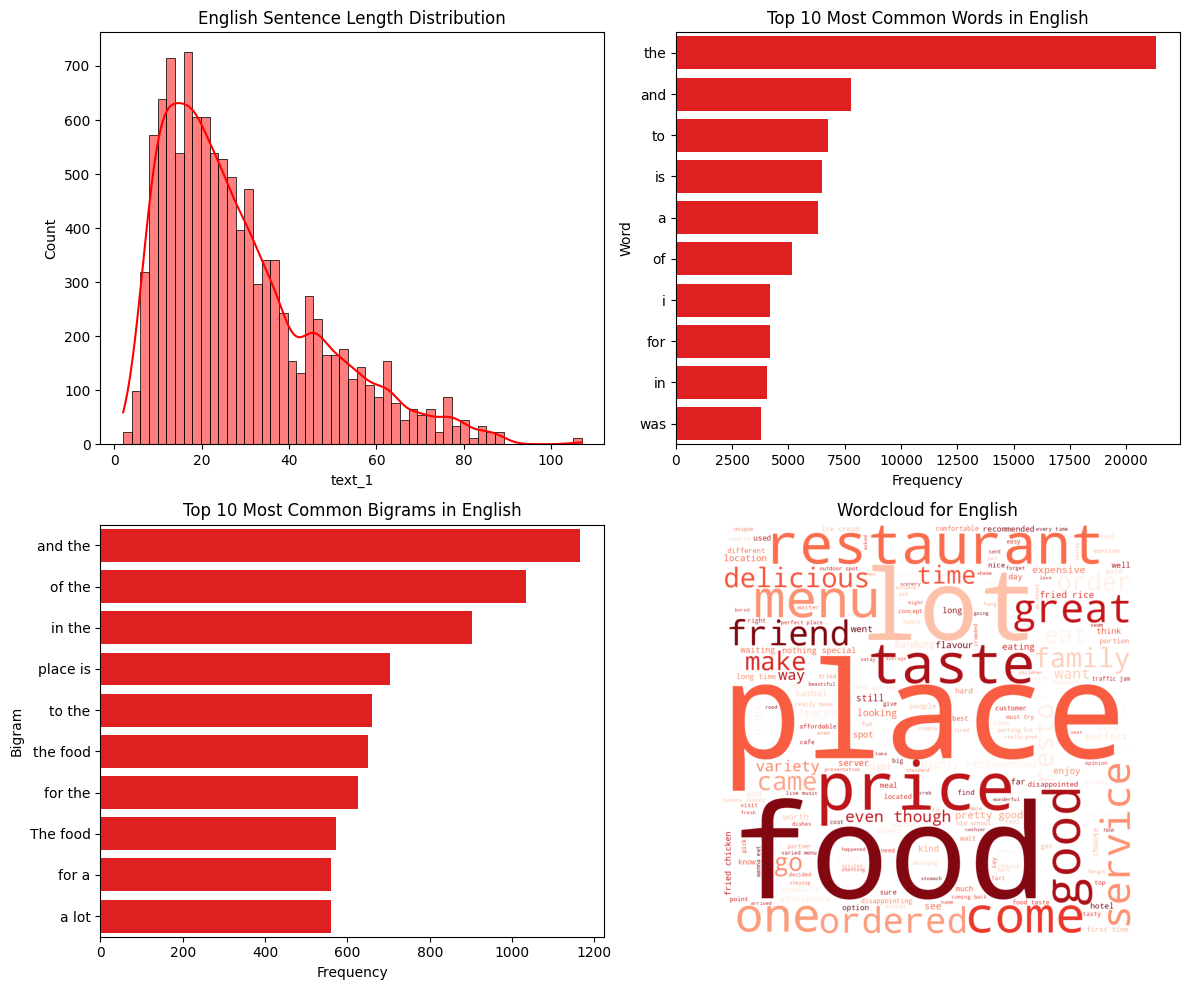

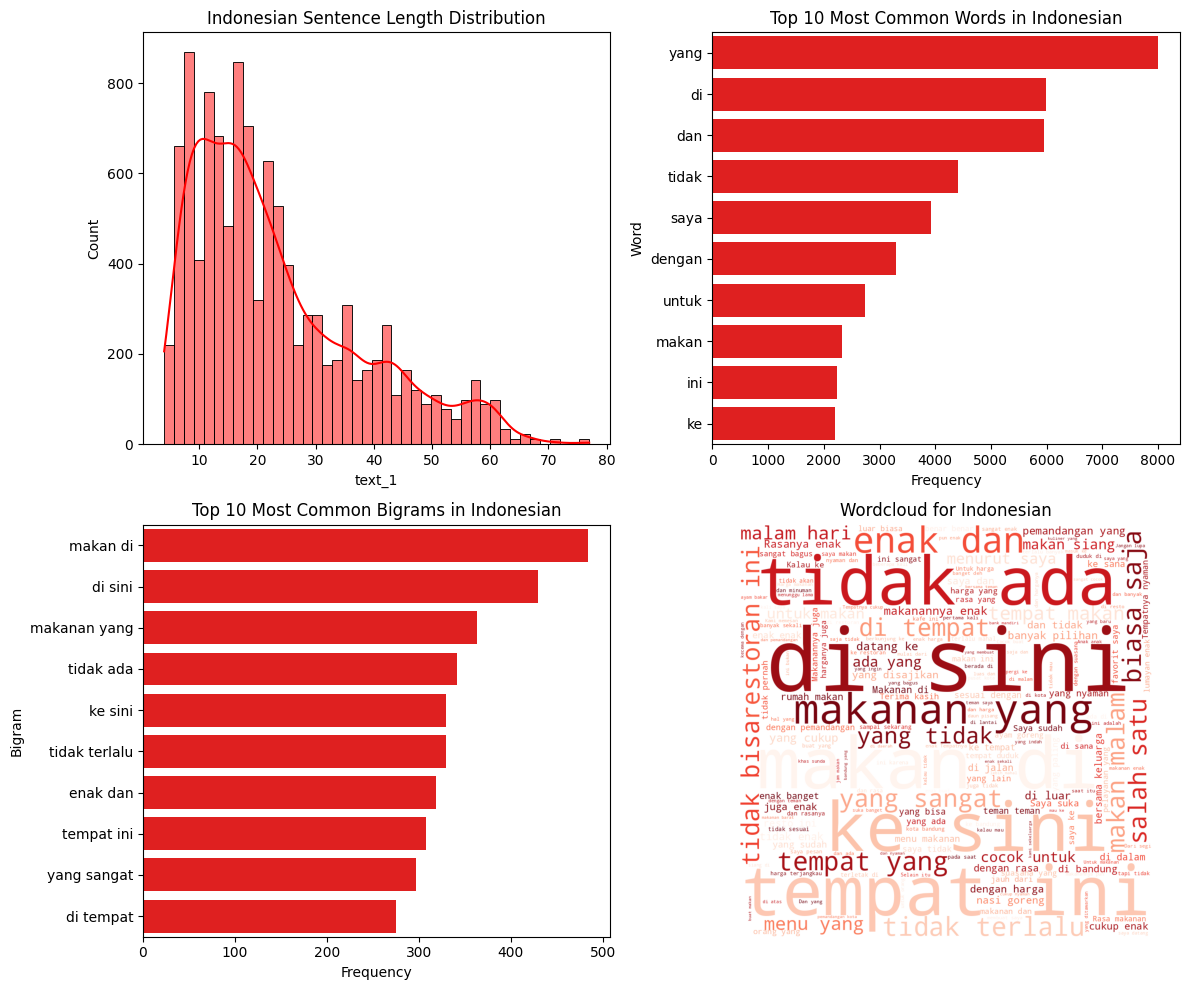

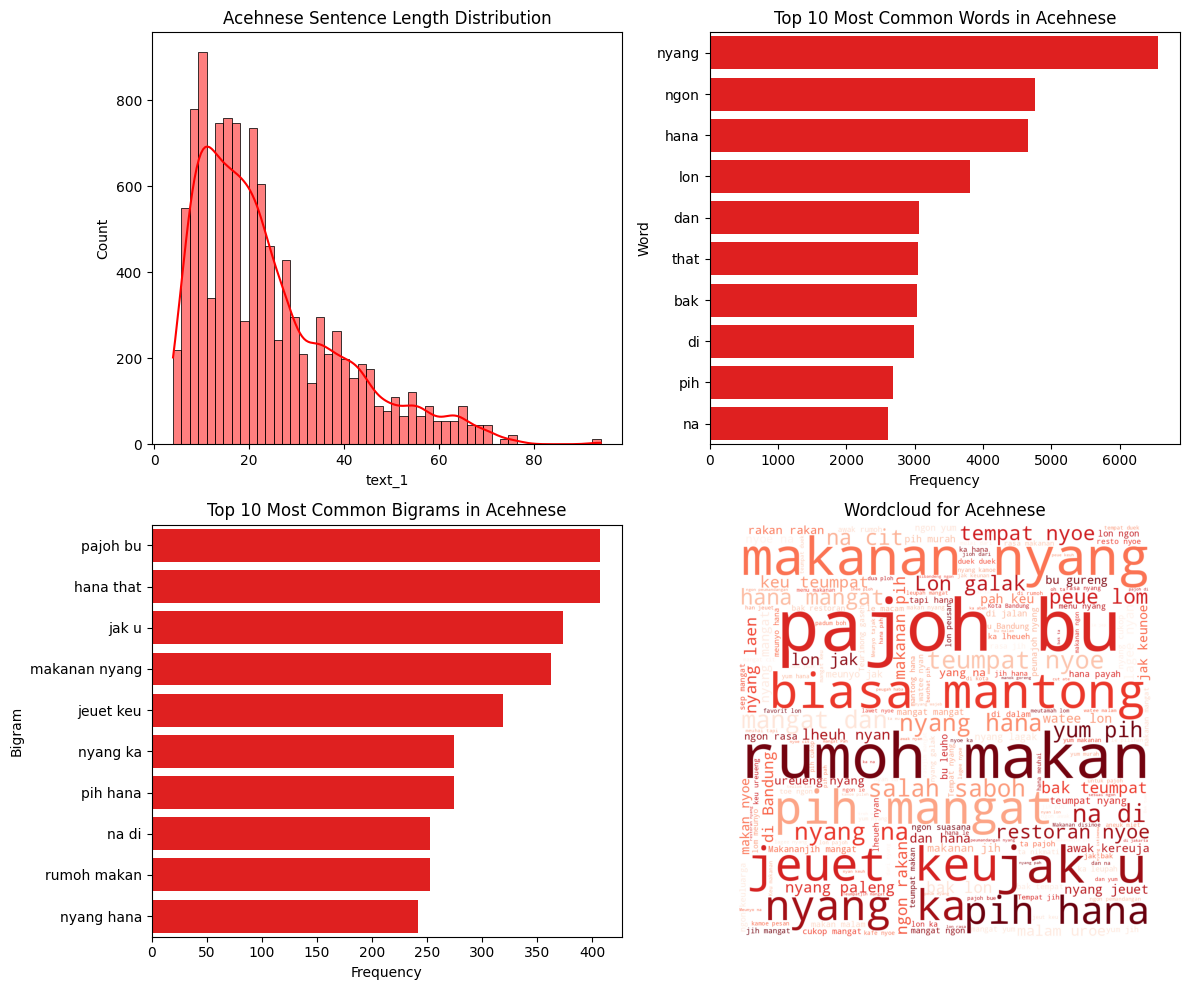

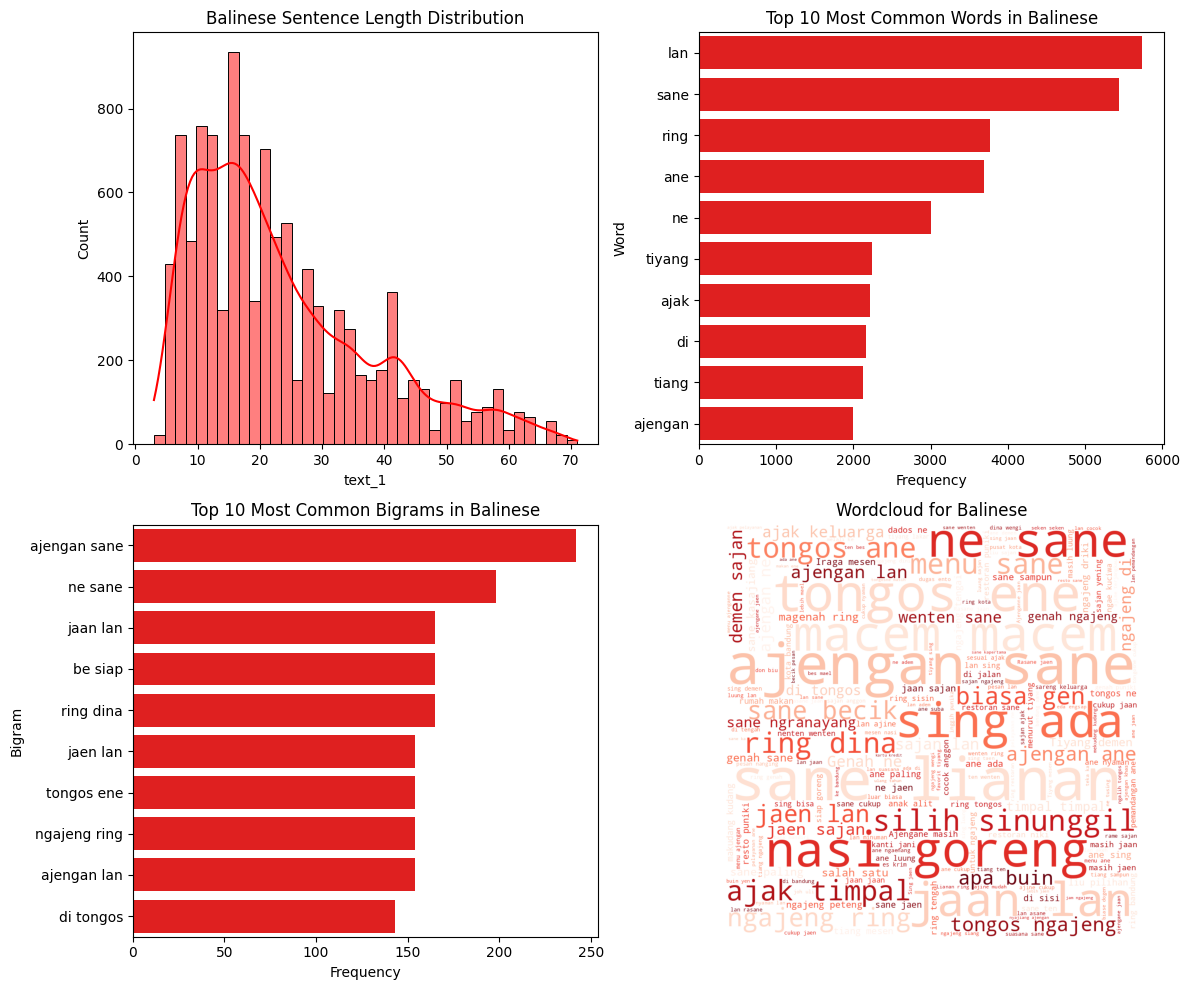

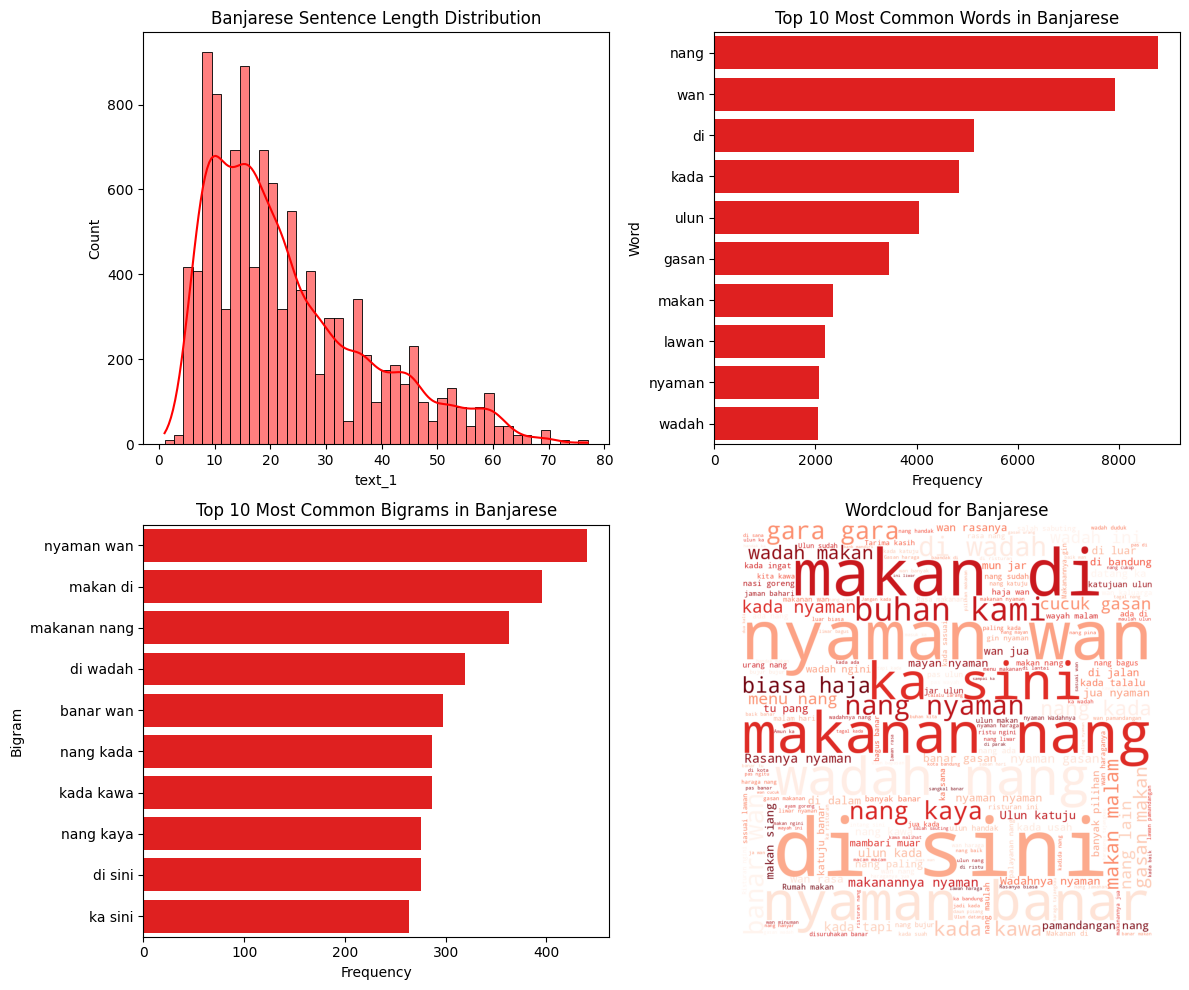

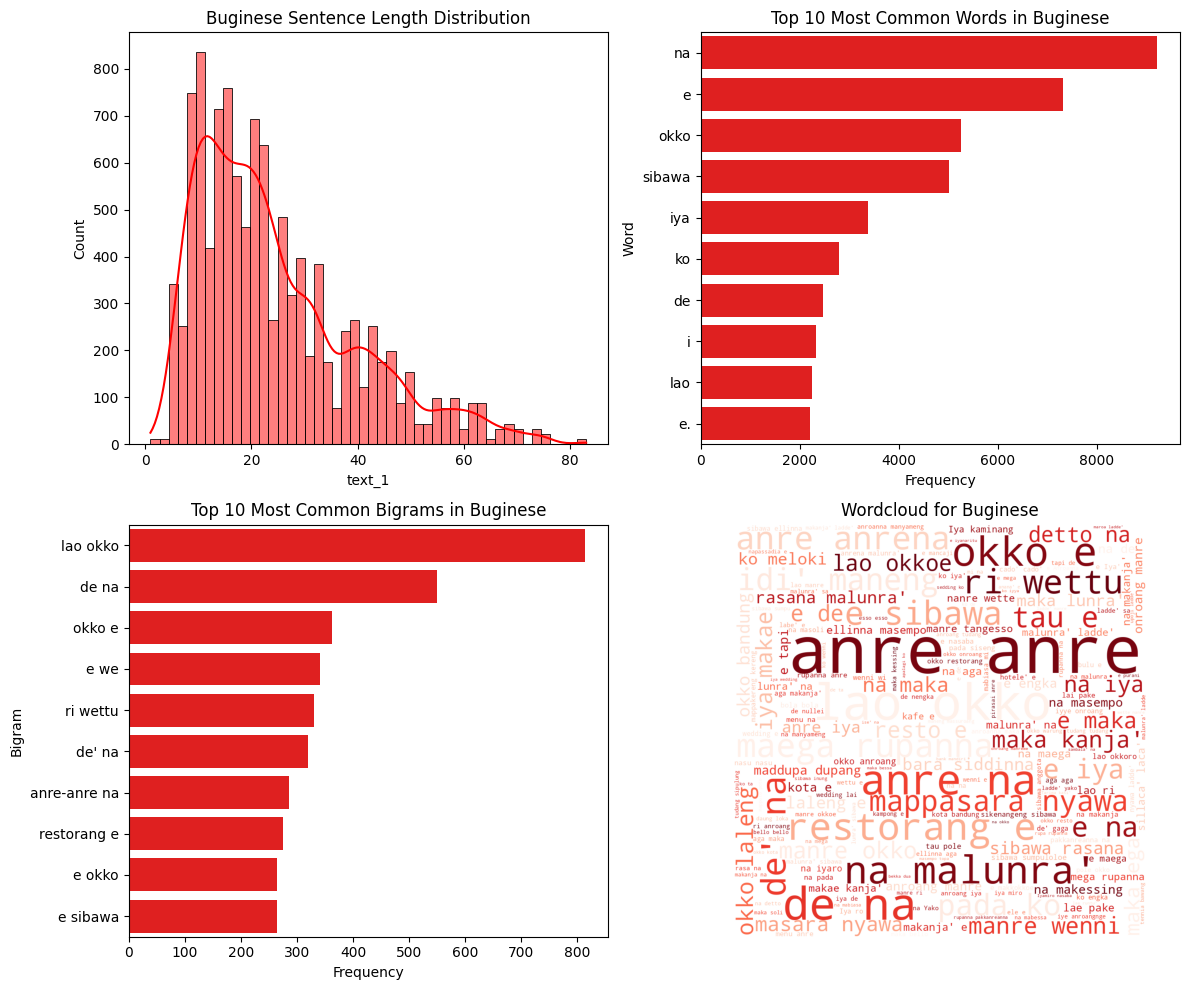

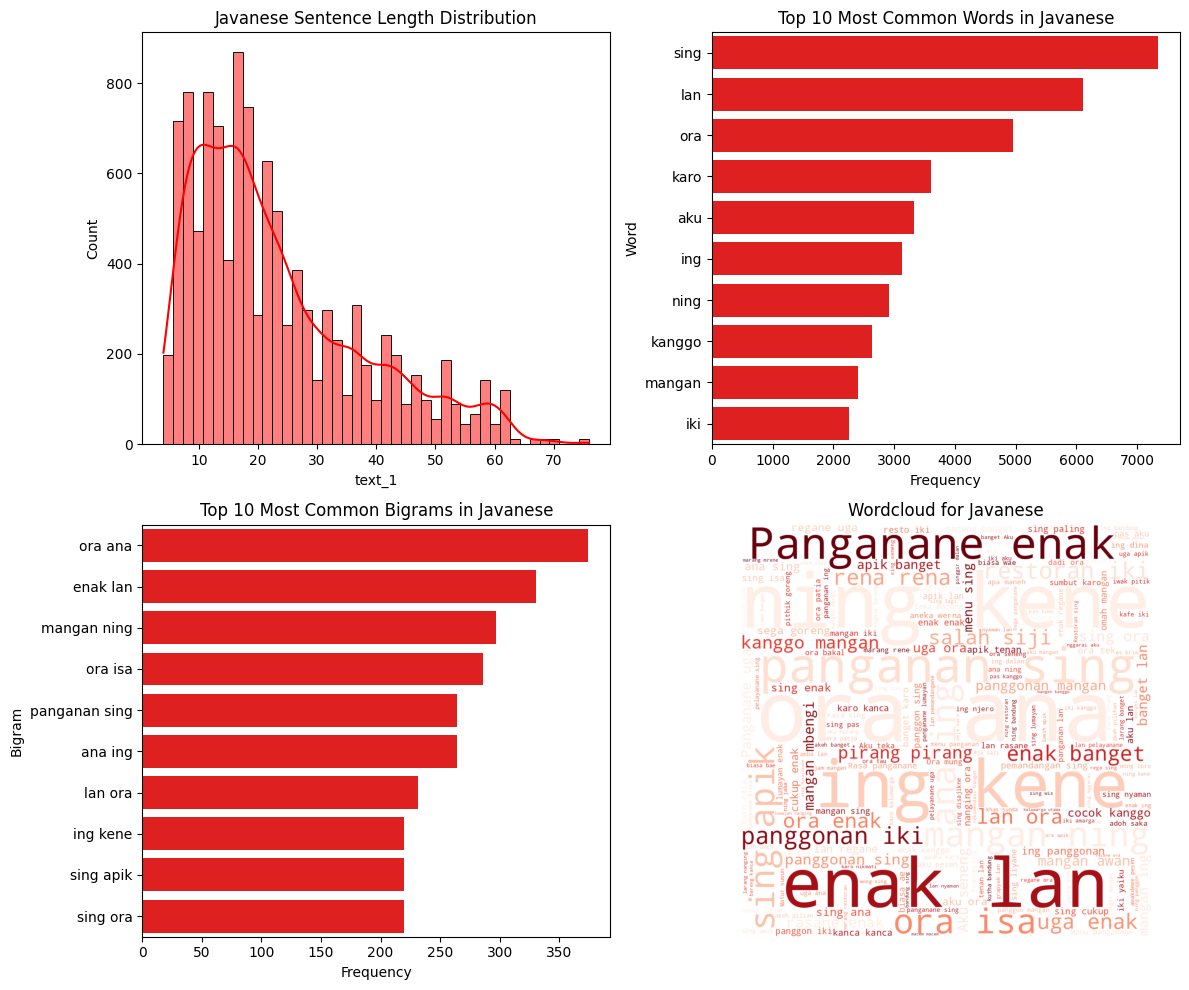

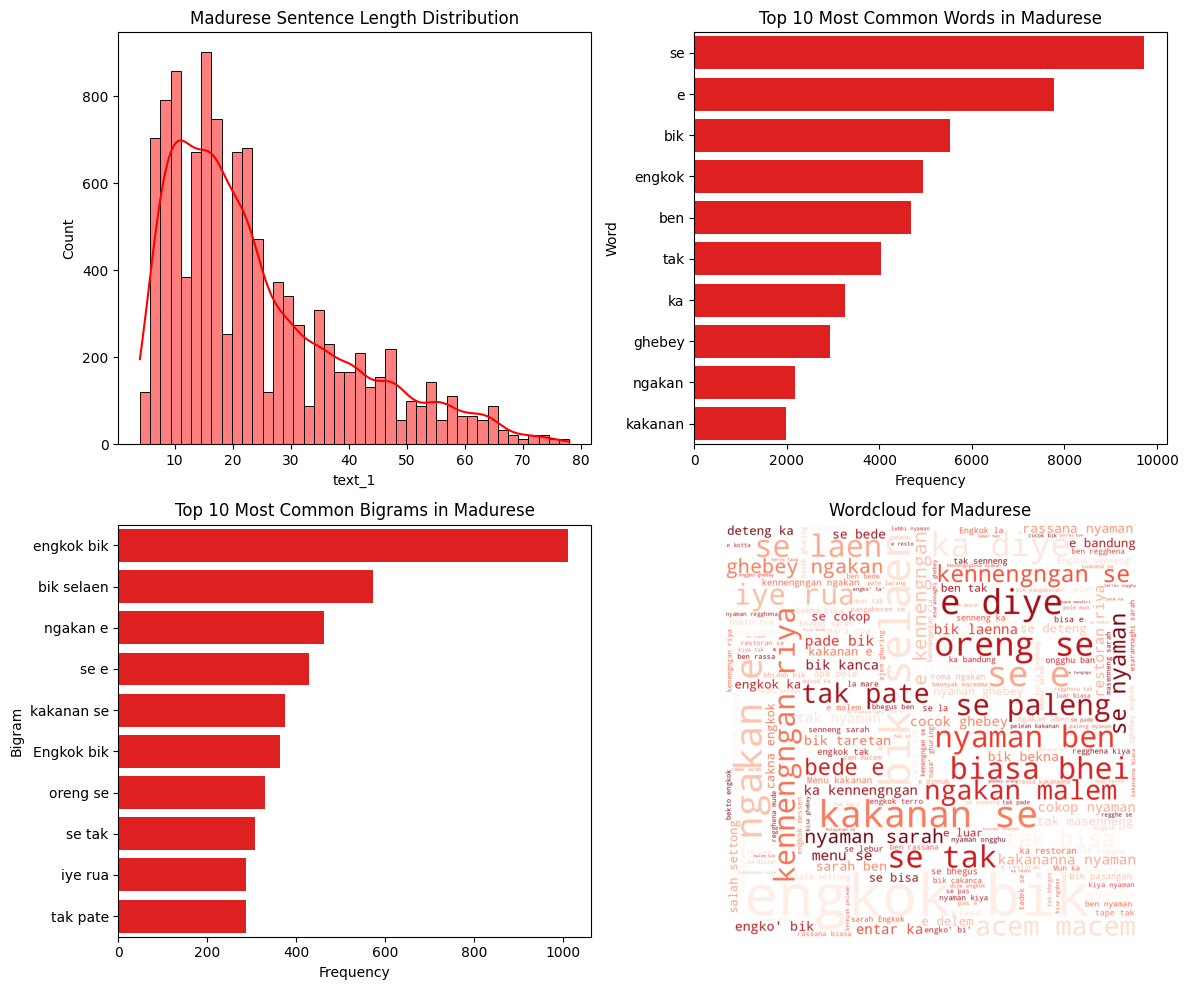

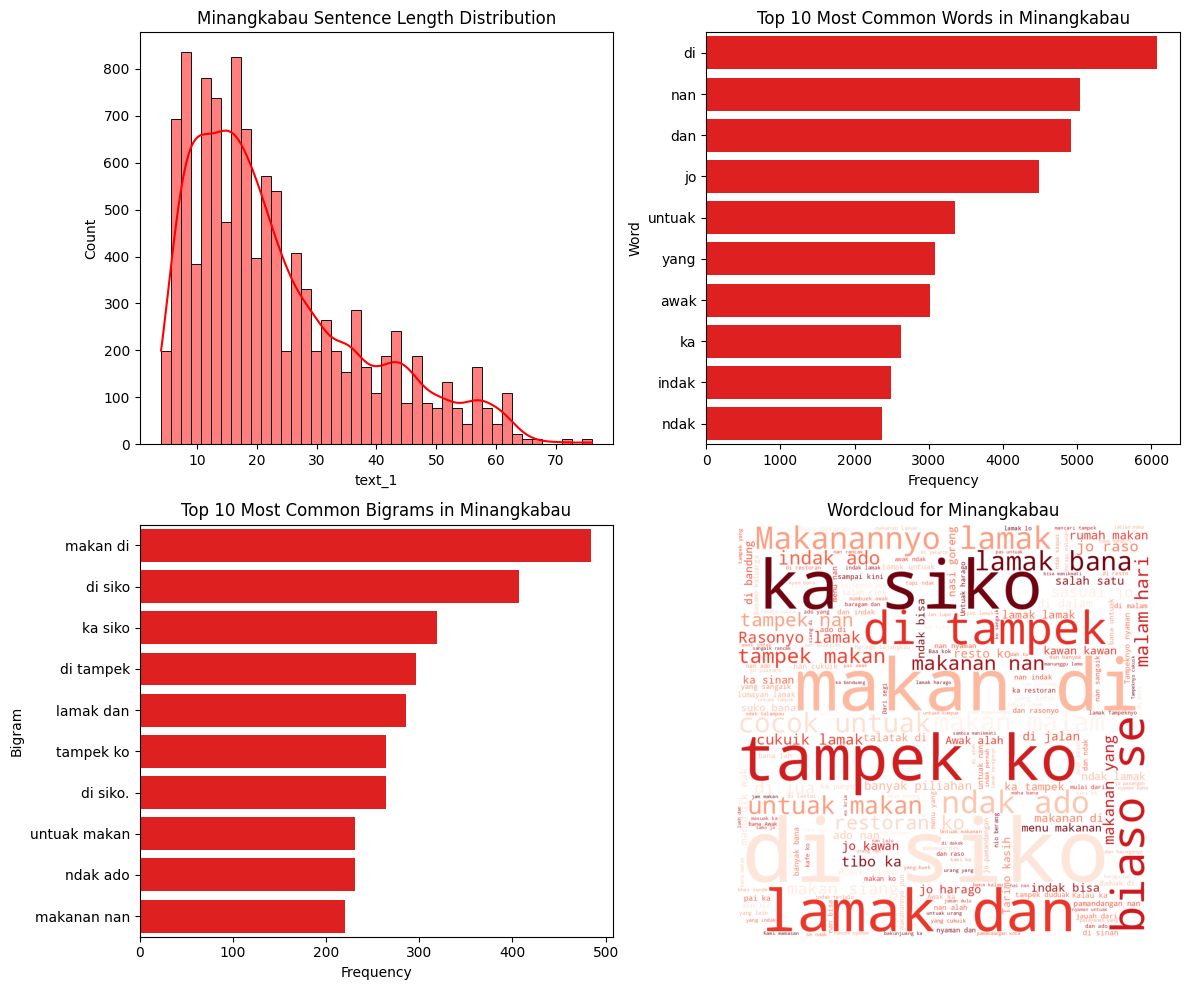

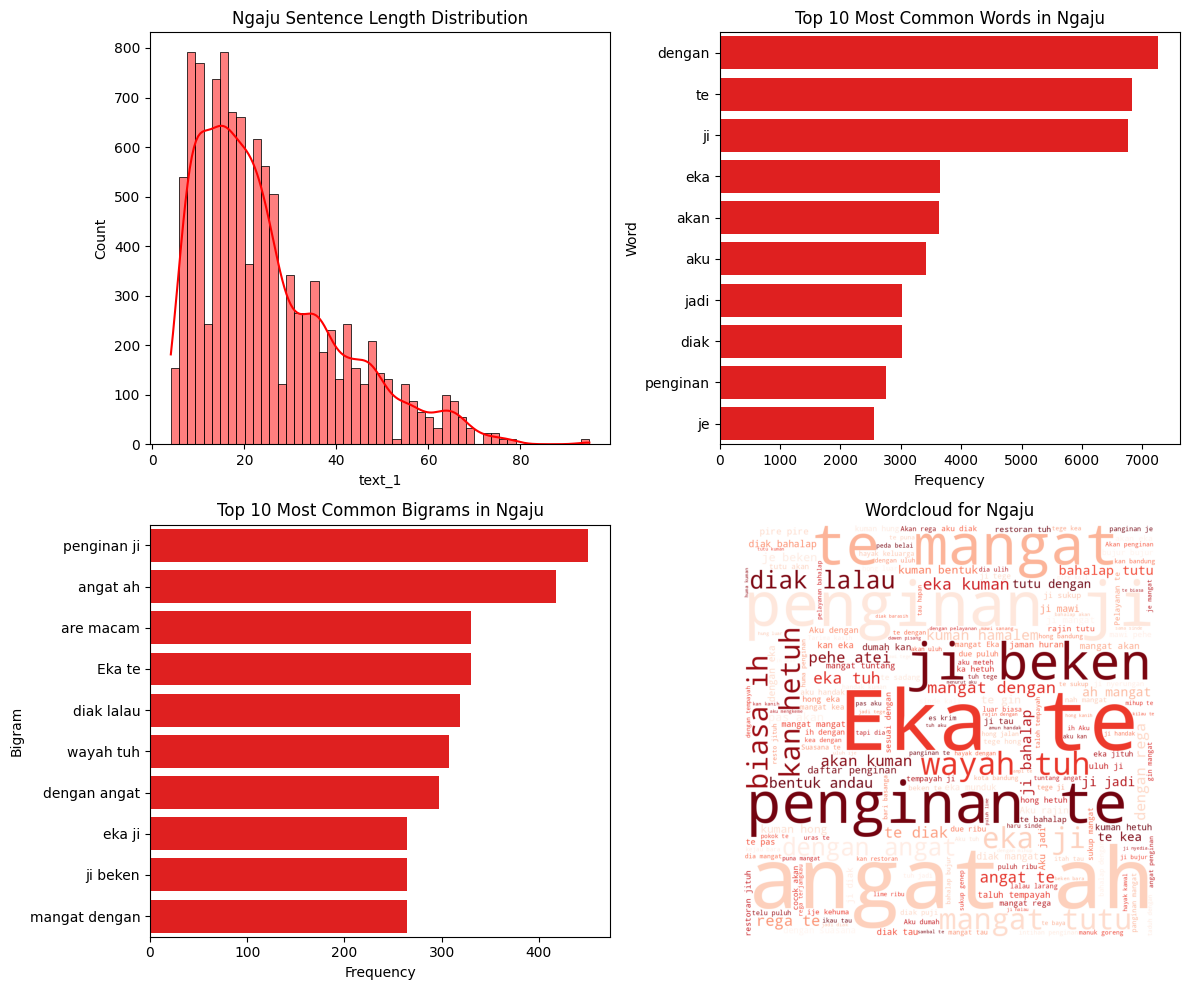

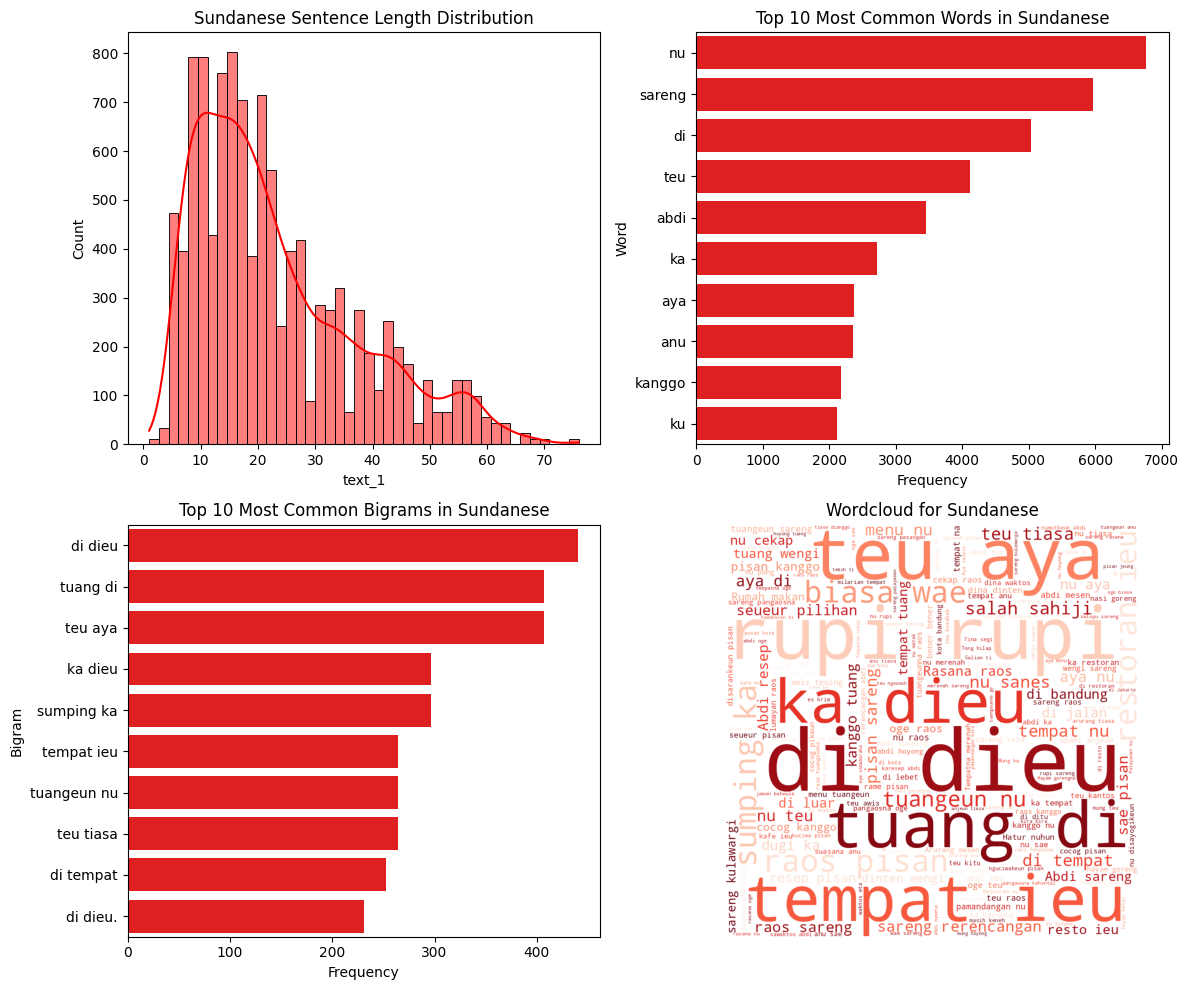

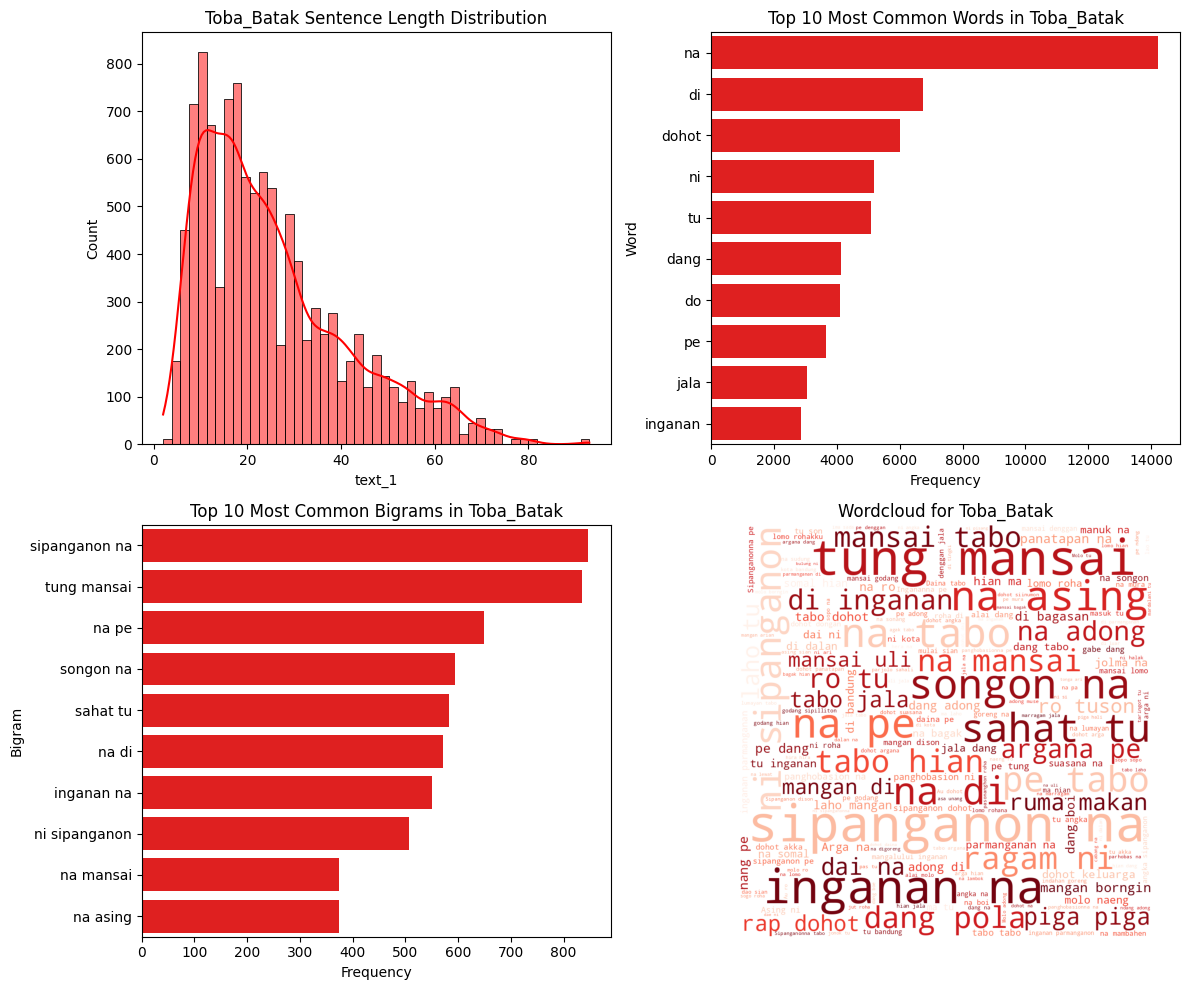

In [10]:


def plot_word_cloud(text, title):
    colormap = 'Reds'
    wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap=colormap).generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    # plt.show()

# Updated function to plot common words, n-grams, and sentence length distribution
def plot_common_words_and_ngrams(df, language_code, language_name):
    main_color = 'red'
    # Filter dataframe for the current language
    df_lang = df[df['text_1_lang'] == language_code]
    texts = df_lang['text_1'].tolist()  # Assuming text_1 contains the sentences

    # Get 10 most common words
    top_words = get_most_common_words(df_lang['text_1'], 10)
    # Get top 10 bigrams
    bigrams = generate_ngrams(" ".join(texts), 2)
    top_bigrams = Counter(bigrams).most_common(10)

    plt.figure(figsize=(12, 10))

    # Sentence Length Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df_lang['text_1'].str.split().map(len), kde=True, color=main_color)
    plt.title(f'{language_name} Sentence Length Distribution')

    # 10 Most Common Words
    plt.subplot(2, 2, 2)
    df_vis = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=df_vis, color=main_color)
    plt.title(f"Top 10 Most Common Words in {language_name}")

    # Bigrams
    plt.subplot(2, 2, 3)
    df_bigrams = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
    sns.barplot(x='Frequency', y='Bigram', data=df_bigrams, color=main_color)
    plt.title(f"Top 10 Most Common Bigrams in {language_name}")

    # Word Cloud
    plt.subplot(2, 2, 4)
    # plot_word_cloud(texts, f"Wordcloud for {language_name}")
    colormap = 'Reds'
    wordcloud = WordCloud(width=1000, height=1000, background_color ='white', colormap=colormap).generate(" ".join(texts))
    # plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Wordcloud for {language_name}")

    plt.tight_layout()
    plt.show()

# Loop over each language
for language in languages:
    plot_common_words_and_ngrams(nusax_df_concated, language['code'], language['name'])

# Create Tokenizer

Since T5 have no vocabulary for Indonesian Local Languages so we need to create the tokenizer with our vocabulary. But since i have no other datasets im gonna using NusaX as the Vocabulary for training the tokenizer. In this study we gonna using [BPE](https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE/) model.

First we need to load the existing tokenizer cause we gonna train T5 model so we load the T5 tokenizer to.

In [11]:
from transformers import AutoTokenizer

checkpoint = "t5-small"
# tokenizer = T5Tokenizer.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [12]:
tokenizer.is_fast

True

for this study we gonna use the nusax as our training corpus for the tokenizer

In [13]:
# Concatenate source and target sentences to create a training corpus
training_corpus = nusax_df_concated['text_1'] + " " + nusax_df_concated['text_2']

display(training_corpus)

0         Neumeuseunang ngon neubayeue bacut-bacut angsu...
1         Kueh nyang dihidang peuingat lon masa dilee. B...
2         Ibu tom geukereuja bak Grab Indonesia Ibu naen...
3         Paleng galak ta pajoh bu leuho inoe, manok ngo...
4         Peulayanan bus DAMRI cukop get Pelayanan bus D...
                                ...                        
131995    Tolong jolo paboa atm na didia do di semarang ...
131996    Dongan mangarekomendasihon inganan on alani da...
131997    Parjolo sahali au ro tuson dang apala lomo roh...
131998    Inganan na tabo, denggan laho tu akka naung ma...
131999    Parpudi on nungga dua hali ro suhul di lombok....
Length: 132000, dtype: object

In [14]:
tokenizer.vocab_size

32100

In [15]:
# vocab_dataset = DatasetHF.from_pandas(pd.DataFrame(training_corpus, columns=['text']))

# display(vocab_dataset['__index_level_0__'])

In [16]:
# Create a generator object
# def get_training_corpus():
#     for start_idx in tqdm(range(0, len(vocab_dataset), 100)):
#         samples = vocab_dataset[start_idx : start_idx + 100]
#         print(samples)
#         yield samples

batch_size = 1000
all_texts = [training_corpus[i : i + batch_size] for i in range(0, len(training_corpus), batch_size)]

def batch_iterator():
    for i in range(0, len(training_corpus), batch_size):
        yield training_corpus[i : i + batch_size]

# training_corpus = get_training_corpus()

new_vocab_size = tokenizer.vocab_size + 1000

new_tokenizer = tokenizer.train_new_from_iterator(
  batch_iterator(),
  new_vocab_size,
  show_progress=True,
)

after train the tokenizer we need to test the tokenizer

In [17]:
encoded_input = new_tokenizer(nusax_df_concated['text_1'][0], return_tensors="pt")
decoded_output = new_tokenizer.decode(encoded_input["input_ids"][0])

print(f"""
encoded: {encoded_input['input_ids'].tolist()}
decoded: {decoded_output}
""")


encoded: [[10878, 21168, 167, 187, 2136, 5618, 2613, 135, 19813, 13802, 1669, 104, 965, 4686, 2238, 108, 422, 2631, 104, 3706, 305, 155, 104, 2178, 496, 6801, 109, 209, 120, 14634, 187, 15852, 1154, 2567, 142, 1]]
decoded: Neumeuseunang ngon neubayeue bacut-bacut angsuran 0% persen sampoe dua blah buleuen keu nyang bloe tiket kapai teureubang ngon keureutu kredit BNI!</s>



In [18]:
new_tokenizer.save_pretrained('/content/drive/MyDrive/Models/TOKENIZER/T5-NusaX-MT-toeknizer-pt')

('/content/drive/MyDrive/Models/TOKENIZER/T5-NusaX-MT-toeknizer-pt/tokenizer_config.json',
 '/content/drive/MyDrive/Models/TOKENIZER/T5-NusaX-MT-toeknizer-pt/special_tokens_map.json',
 '/content/drive/MyDrive/Models/TOKENIZER/T5-NusaX-MT-toeknizer-pt/tokenizer.json')

## Datasets Preprocessing

Here we gonna splits the convert our dataframes into HuggingFace Datasets, and after that we splits the datasets become 80% train, 10% test, 10% validation, and concate the datasets. After that we vectorize and tokenize the datasets using tokenizer from T5.

First we need to convert the Dataframe into HF dataset again, and split the dataset manual

In [19]:
for idx in range(len(nusax_df_concated)):
  input_lang = next(item['name'] for item in languages if item['code'] == nusax_df_concated['text_1_lang'][idx])
  target_lang = next(item['name'] for item in languages if item['code'] == nusax_df_concated['text_2_lang'][idx])
  prefix = f"Translate {input_lang} to {target_lang} : "
  nusax_df_concated['text_1'][idx] = prefix + nusax_df_concated['text_1'][idx]

display(nusax_df_concated)

<ipython-input-19-15f06f668b36>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nusax_df_concated['text_1'][idx] = prefix + nusax_df_concated['text_1'][idx]


id                                             text_1  \
0           0  Translate Acehnese to Balinese : Neumeuseunang...   
1           1  Translate Acehnese to Balinese : Kueh nyang di...   
2           2  Translate Acehnese to Balinese : Ibu tom geuke...   
3           3  Translate Acehnese to Balinese : Paleng galak ...   
4           4  Translate Acehnese to Balinese : Peulayanan bu...   
...       ...                                                ...   
131995  13195  Translate Toba_Batak to Sundanese : Tolong jol...   
131996  13196  Translate Toba_Batak to Sundanese : Dongan man...   
131997  13197  Translate Toba_Batak to Sundanese : Parjolo sa...   
131998  13198  Translate Toba_Batak to Sundanese : Inganan na...   
131999  13199  Translate Toba_Batak to Sundanese : Parpudi on...   

                                                   text_2 text_1_lang  \
0       Nikmati cicilan 0% kanti 12 bulan antuk pemesa...         ace   
1       Jaje-jaje ne sane kasajiang ngaenang tiang ber...         ace   
2                 Ibu naenang makarya ring grab Indonesia         ace   
3       Paling demen sajan ngajeng siang driki be siap...         ace   
4                       Pelayanan bus DAMRI luung pesan.          ace   
...                                                   ...         ...   
131995  Mohon informasikeun atm mana wae di semarang n...         bbc   
131996  Rerencangan nyarankeun tempat ieu kusabab rasa...         bbc   
131997  Mimiti kuring kadieu nganggap enteng, sawaktos...         bbc   
131998  Tempatna nyenengkeun nya kanggo nu atos berkul...         bbc   
131999  Katukang ieu tos kajadian dua kali gempa di lo...         bbc   

       text_2_lang  text_1_length  text_2_length  
0              ban             21             16  
1              ban             22             22  
2              ban              6              6  
3              ban             63             63  
4              ban              5              5  
...            ...            ...            ...  
131995         sun             17             17  
131996         sun             37             37  
131997         sun             43             38  
131998         sun             54             42  
131999         sun              9              9  

[132000 rows x 7 columns]

In [20]:
nusaX = DatasetHF.from_pandas(nusax_df_concated)

display(nusaX)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 132000
})

In [21]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits_nusaX = nusaX.train_test_split(test_size=0.2)
train_dataset, valid_test_dataset = splits_nusaX['train'], splits_nusaX['test']

splits_nusaX = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits_nusaX['train'], splits_nusaX['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 105600
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 13200
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 13200
})

#### Check the languages distribution

since we split again the datasets we also need to check again the language distribution

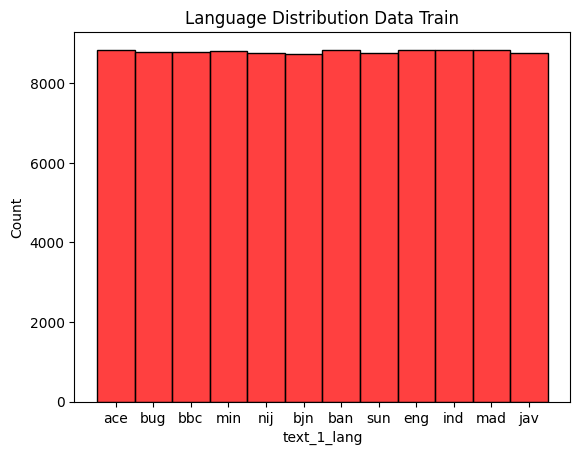

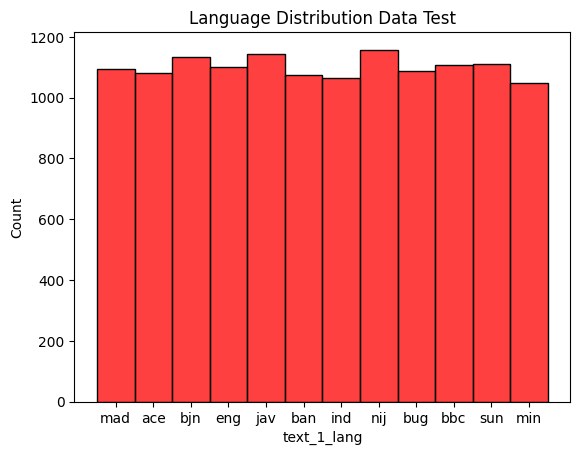

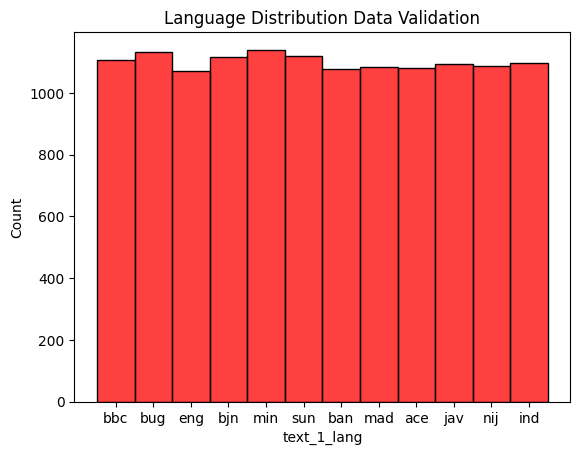

In [22]:
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()
val_df = valid_dataset.to_pandas()

sns.histplot(train_df['text_1_lang'], color='red')
plt.title(f'Language Distribution Data Train')
plt.show()

sns.histplot(test_df['text_1_lang'], color='red')
plt.title(f'Language Distribution Data Test')
plt.show()

sns.histplot(val_df['text_1_lang'], color='red')
plt.title(f'Language Distribution Data Validation')
plt.show()

### Load Tokenizer

now we need to load our pretrained Tokenizer

In [23]:
from transformers import T5Tokenizer

checkpoint = "t5-small"
tokenizer_path = "/content/drive/MyDrive/Models/TOKENIZER/T5-NusaX-MT-toeknizer-pt"
tokenizer_T5pt = AutoTokenizer.from_pretrained(tokenizer_path)


In [24]:
# Test the tokenizer
text = train_dataset['text_1'][0]
encoded_input = tokenizer_T5pt(text, return_tensors="pt")
decoded_output = tokenizer_T5pt.decode(encoded_input["input_ids"][0])

print(f"""
encoded: {encoded_input}
decoded: {decoded_output}
""")


encoded: {'input_ids': tensor([[ 3425,   128, 17921,  9309,   114,  5676,   137,  1510,  5676,   104,
           379,   707,  2711,   608,   108,   115,   262, 13179,   104,   430,
           104, 14590,   106,  1255,   122,   109,   106,   103,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}
decoded: Translate Acehnese to Balinese : Lon cemburu meueu awak droen jeuet neurasa bahgia.</s>



The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [26]:
def preprocess_function(examples):

    inputs = examples["text_1"]
    targets = examples["text_2"]
    model_inputs = tokenizer_T5pt(inputs, max_length=300, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer_T5pt.as_target_tokenizer():
        labels = tokenizer_T5pt(targets, max_length=300, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/105600 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13200 [00:00<?, ? examples/s]

Map:   0%|          | 0/13200 [00:00<?, ? examples/s]

In [27]:
display(tokenized_nusax_train['input_ids'][1])
display(tokenized_nusax_train['labels'][1])

[3425,
 128,
 17921,
 2522,
 122,
 109,
 5676,
 137,
 10798,
 13899,
 6204,
 106,
 4712,
 104,
 379,
 18626,
 19538,
 109,
 174,
 2316,
 2316,
 172,
 10076,
 105,
 1005,
 163,
 104,
 3384,
 104,
 109,
 9822,
 361,
 225,
 745,
 394,
 104,
 108,
 840,
 4548,
 402,
 8483,
 113,
 256,
 2951,
 10194,
 104,
 109,
 231,
 2323,
 2951,
 11946,
 8814,
 111,
 109,
 379,
 1123,
 4846,
 301,
 105,
 1123,
 809,
 113,
 6490,
 361,
 105,
 1123,
 1595,
 22497,
 105,
 104,
 108,
 3108,
 1590,
 107,
 23394,
 113,
 11708,
 115,
 2584,
 301,
 104,
 1981,
 104,
 171,
 109,
 359,
 2359,
 109,
 2695,
 103,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

[13365,
 104,
 128,
 1469,
 6276,
 135,
 19381,
 140,
 456,
 254,
 112,
 7894,
 329,
 2806,
 109,
 361,
 18163,
 6117,
 110,
 182,
 402,
 8483,
 206,
 1145,
 218,
 4348,
 775,
 1243,
 16173,
 167,
 345,
 23330,
 106,
 1920,
 9085,
 379,
 1111,
 301,
 200,
 105,
 809,
 200,
 165,
 361,
 1051,
 105,
 351,
 1932,
 105,
 165,
 104,
 108,
 112,
 5285,
 251,
 775,
 104,
 109,
 857,
 10699,
 112,
 5119,
 301,
 104,
 1981,
 5044,
 20982,
 106,
 107,
 1920,
 6044,
 103,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

## Model Development and Optimization

Load the metrics, we using several mterics for this project

- Bleu: Bilingual evaluation understudy (BLEU) is an automatic evaluation metric used to measure the similarity of the hypothesis to the reference. BLEU measures both adequacy by looking at word precision and fluency by calculating n-gram precision for n =1,2,3,4.
- Meteor: The metric for evaluation of translation with explicit ordering (METEOR) is a metric designed to address the limitations of BLEU, which is a commonly used evaluation metric for machine translation.  For instance, BLEU does not consider the stems and synonyms of words, meaning that it does not match “running” and “runs”, as they are not counted as the same word in the n-gram matching process. Additionally, BLEU does not use recall, which results in short sentences being penalized.
- Bleurt: BLEURT is a pre-trained model with a BERT structure using multi-task loss on synthetic data of a large number of references. It is a sentence-level metric that learns prediction scores that explain the similarity between the hypothesis and references.
- BertScores: BERTscore compares the hypothesis and reference statements of the translator using features extracted by BERT that is trained for the masked language model and next sentence prediction. BERTscore uses token embeddings of the pre-trained BERT.

And create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [28]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
import evaluate

# model_path = "/content/drive/MyDrive/Models/T5-small-CC100-SU-JV-02"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")
bluert_metrics = evaluate.load("bleurt", module_type="metric")

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_T5pt, model=model)



config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


compute metrics function for the metrics we gonna use Bleu, Meteor, Bleurt and BertScore to see the accuracy with various type metrics

In [29]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    # Flatten the list of lists for labels into a list of strings
    # labels = [label.strip() for sublist in labels for label in sublist]
    labels = [label.strip() for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    print(f"Decoded preds: {len(decoded_preds)}, Decoded labels: {len(decoded_labels)}")

    # Check if the number of predictions and references match
    if len(decoded_preds) != len(decoded_labels):
        raise ValueError(f"Number of predictions ({len(decoded_preds)}) does not match number of references ({len(decoded_labels)})")

    # Initialize result dictionary
    result = {}

    # Compute sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # Compute METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]


    # Compute BLEURT
    bleurt_result = bluert_metrics.compute(predictions=decoded_preds, references=decoded_labels)
    # Choose a specific value to log (e.g., mean or median)
    result["Bleurt"] = round(np.mean(bleurt_result['scores']), 4)


    # Compute BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="id")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    # result = {k: round(v, 4) for k, v in result.items()}

    # Round specific metrics
    result["bleu"] = round(result["bleu"], 4)
    result["meteor"] = round(result["meteor"], 4)
    result["bertscore_precision"] = round(result["bertscore_precision"], 4)
    result["bertscore_recall"] = round(result["bertscore_recall"], 4)
    result["bertscore_f1"] = round(result["bertscore_f1"], 4)
    result["gen_len"] = round(result["gen_len"], 4)

    return result

In [30]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"T5-NusaX_checkpoints",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 13200, Decoded labels: 13200


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 13200, Decoded labels: 13200


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Decoded preds: 13200, Decoded labels: 13200


TrainOutput(global_step=19800, training_loss=0.9652076998623935, metrics={'train_runtime': 7261.621, 'train_samples_per_second': 43.627, 'train_steps_per_second': 2.727, 'total_flos': 2.14381413531648e+16, 'train_loss': 0.9652076998623935, 'epoch': 3.0})

Save the model to drive, or you aslo can push the model to HuggingFace if you want.

In [31]:
model_name = f"/content/drive/MyDrive/Models/T5-small-NusaX-FULL_model"
trainer.save_model(model_name)

## Predict Evaluate

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from new languge to another new language, you should prefix your input as we when divined the translation task:

First we need to test the model with one sentence to make sure if it realy works

In [33]:
from transformers import pipeline

input = f"Translate Sundanese to Acehnese : Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!"

translator = pipeline("translation", model=model_name)
output = translator(input)

print(f"""
input  : {input}
output : {output}
""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(



input  : Translate Sundanese to Acehnese : Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!
output : [{'translation_text': 'Sundanese zu Acehnese : Nikmati angsuran 0% dugi ka 12 bulan kanggo mesen tiket pasawat air asia nganggo kartu kiridit BNI!'}]



In [ ]:
def predict_evaluate(data):
    try:
        sources = data['text_1']
        targets = data['text_2']
        predictions = [translator(source)[0]['translation_text'] for source in sources]

        # Initialize lists to store results
        predicts, accuracies, bleus, meteors, bleurts, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            # Calculate accuracy for each prediction
            accuracies.append(int(prediction == target))

            # Compute sacreBLEU
            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            # Compute METEOR
            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            # Compute Bleurt
            bleurt_result = bluert_metrics.compute(predictions=[prediction], references=[target])
            bleurts.append(bleurt_result['scores'])

            # Compute BERTScore
            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="id")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        # Return a dictionary with lists as values
        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            # "accuracy": accuracies,  # Now a list of accuracies
            "bleu": bleus,
            "meteor": meteors,
            "bleurt": bleurts,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None

# Assuming test_dataset is correctly defined
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)

Parameter 'function'=<function predict_evaluate at 0x7f209c194670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/13200 [00:00<?, ? examples/s]

Your input_length: 276 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 310 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 290 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 283 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [ ]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
    ],
    axis=1)
)

In [ ]:
display(predict_eval_df.drop(
    [
        'text_1', 'text_2',
        'text_1_lang', 'text_2_lang',
        'text_1_length', 'text_2_length',
        # 'input',
        # 'bleu',
        # 'meteor',
        # 'bleurt',
        'bertscore_precision',
        'bertscore_recall',
        'bertscore_f1'
    ],
    axis=1)
)

In [ ]:
display(predict_eval_df['bleu'].mean())
display(predict_eval_df['meteor'].mean())
display(predict_eval_df['bleurt'].mean())
display(predict_eval_df['bertscore_precision'].mean())
display(predict_eval_df['bertscore_recall'].mean())
display(predict_eval_df['bertscore_f1'].mean())

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models
- https://www.mdpi.com/2227-7390/11/4/1006
- https://huggingface.co/spaces/evaluate-metric/bertscore#:~:text=Metric%20description,token%20in%20the%20reference%20sentence
- https://huggingface.co/spaces/evaluate-metric/bleurt